In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.nn.functional as functional
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pickle

In [2]:
device = torch.device('cpu')

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
train_file = open('lego-train.pickle', 'rb')
test_file = open('lego-test.pickle', 'rb')
train_data = pickle.load(train_file)
test_data = pickle.load(test_file)

In [5]:
train_data_X = np.array([img for (img, _) in train_data]).astype(np.float32)
train_data_y = np.array([lbl for (_, lbl) in train_data])

test_data_X = np.array([img for (img, _) in test_data]).astype(np.float32)
test_data_y = np.array([lbl for (_, lbl) in test_data])


In [6]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

In [7]:
image_width = 48
image_height = 48


In [8]:
x_train = torch.tensor(train_data_X).to(device)
y_train = torch.tensor(train_data_y).to(device)
x_valid = torch.tensor(test_data_X).to(device)
y_valid = torch.tensor(test_data_y).to(device)

In [9]:
learning_rate = 0.01
epochs = 100
batch_size = 34

In [10]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

In [11]:
class TorchModule(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, image_width, image_height).to(device)

model = nn.Sequential(
    TorchModule(preprocess),
    nn.Conv2d(1, 6, 5, padding=(2,2)),
    nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), 
    nn.ReLU(),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), 
    nn.Flatten(),
    nn.Linear(10*10*16, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
    TorchModule(lambda x: x.view(x.size(0), -1)),
)

In [12]:
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = functional.cross_entropy

In [13]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    history = []
    for epoch in range(epochs):
        
        # First we train:
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        # Then we evaluate:
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        history.insert(epoch,val_loss)
        print('.', end='')
        
    print('[Done]')
    return history

....................................................................................................[Done]


Text(0.5, 0, 'Epoch')

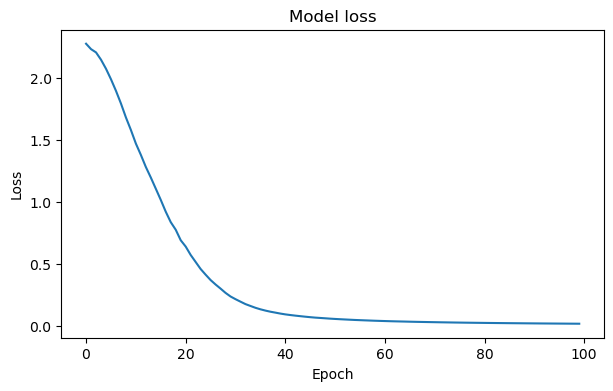

In [14]:
history = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [15]:
def plot_image(predictions_array, true_label, img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((image_width, image_height)), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    # Print a label with 'predicted class', 'probability %', 'actual class'
    plt.xlabel("{} [{:2.0f}] ({})".format(class_names[predicted_label],
                                  np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

# Function to display the prediction results in a graph:
def plot_value_array(predictions_array, true_label):
  plt.xticks(range(10))
  plt.yticks([])
  plot = plt.bar(range(10), predictions_array, color="#777777")
  predicted_label = np.argmax(predictions_array)
  plot[predicted_label].set_color('red')
  plot[true_label].set_color('green')

In [16]:
predictions = model(x_valid)

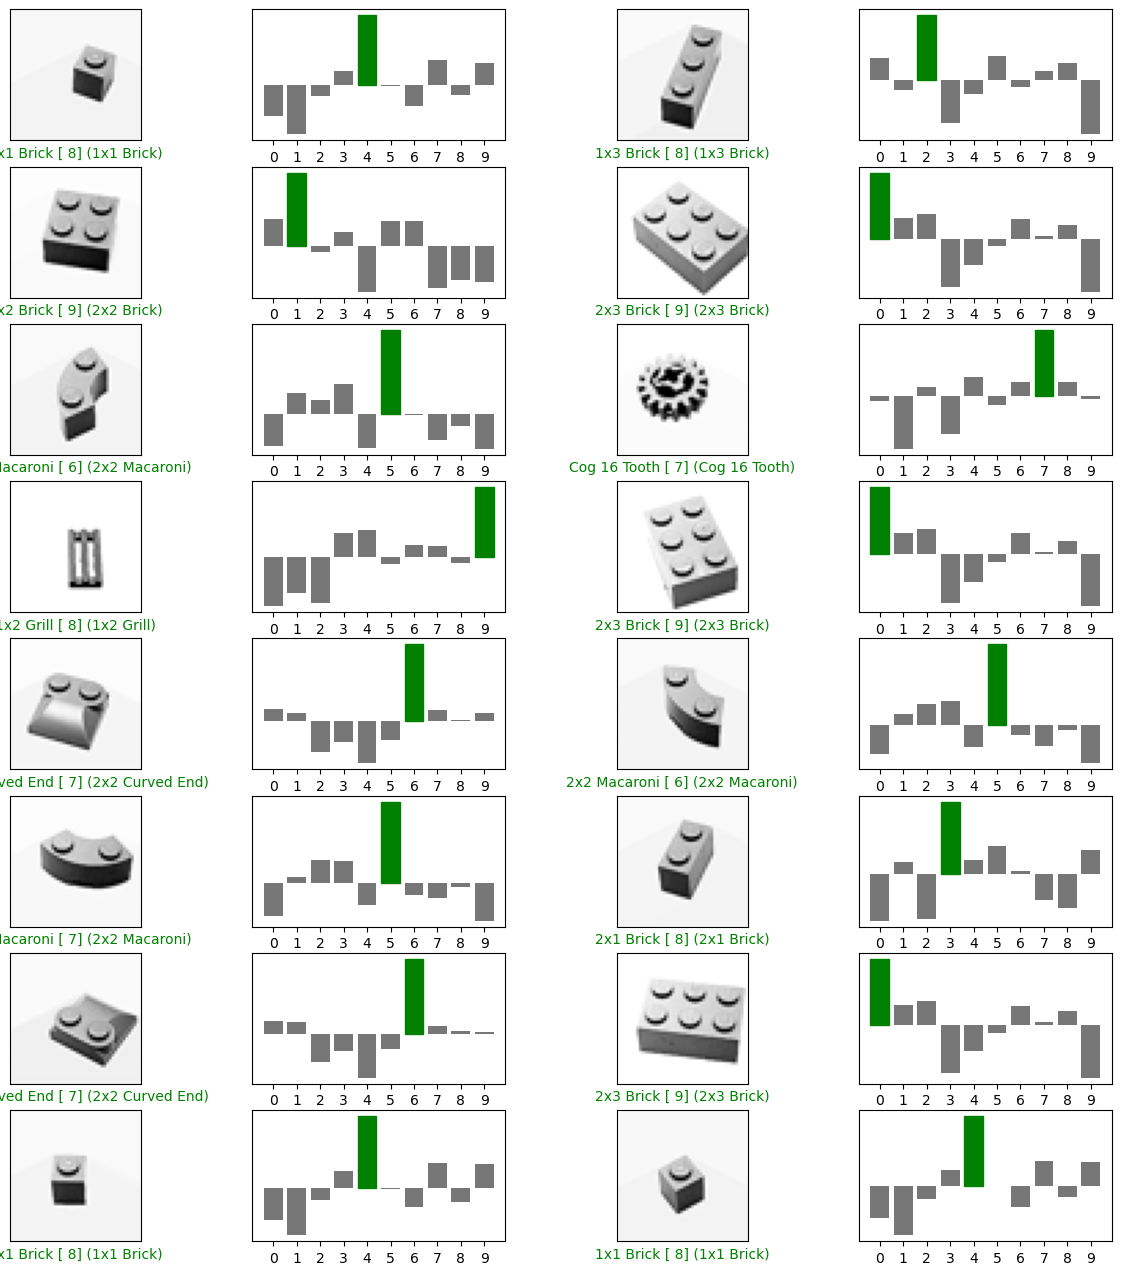

In [17]:
num_rows = 8
num_cols = 2

num_images = num_rows*num_cols
plt.figure(figsize=(15, 16))

for i in range(num_images):
    ipred = predictions[i].detach().numpy()
    iimg = x_train[i].detach().numpy()
    ilab = y_valid[i].detach().numpy()
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(ipred, ilab, iimg)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(ipred, ilab)
plt.show()